In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
import os

# Define directory names
dir_names = ["yes", "no", "augmented data/yes", "augmented data/no"]

# Create directories
for dir_name in dir_names:
    os.makedirs(dir_name, exist_ok=True)

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from os import listdir
import time

%matplotlib inline
     

In [6]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [7]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """

    from os import listdir

    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )


    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir+filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break
     

In [9]:
start_time = time.time()


# augment data for the examples with label equal to 'yes' representing tumurous examples
# D:\Brain tumor Detection\archive
augment_data(file_dir="D:/Brain tumor Detection/archive/yes/", n_generated_samples=2, save_to_dir="D:/Brain tumor Detection/augmented data/yes")
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir="D:/Brain tumor Detection/archive/no/", n_generated_samples=2, save_to_dir="D:/Brain tumor Detection/augmented data/no")

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:4:6.5


In [10]:
def data_summary(main_path):

    yes_path = main_path+'yes'
    no_path = main_path+'no'

    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)

    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [11]:
data_summary("D:/Brain tumor Detection/augmented data/")

Number of examples: 8999
Percentage of positive examples: 50.0055561729081%, number of pos examples: 4500
Percentage of negative examples: 49.9944438270919%, number of neg examples: 4499


In [12]:
def crop_brain_contour(image, plot=False):
  # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

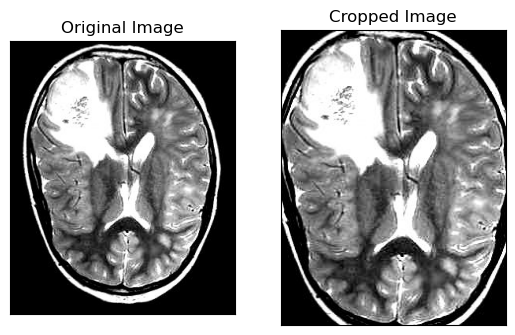

In [13]:
#In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:
ex_img = cv2.imread('D:/Brain tumor Detection/archive/yes/y0.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [14]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [15]:
augmented_path = 'D:/Brain tumor Detection/augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 8999
X shape is: (8999, 240, 240, 3)
y shape is: (8999, 1)


In [18]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
     

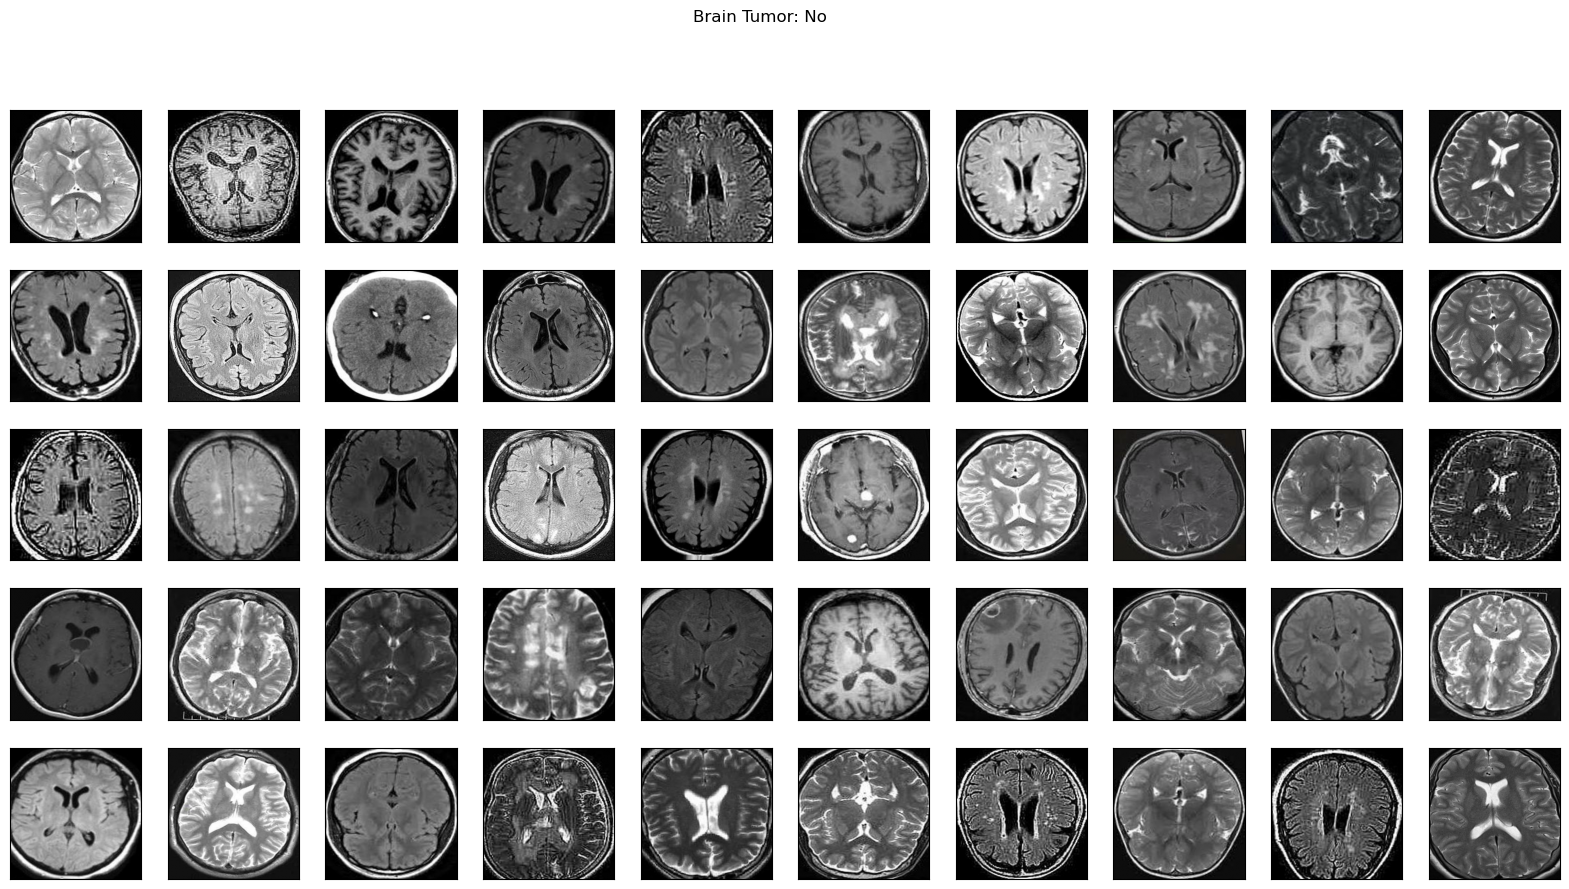

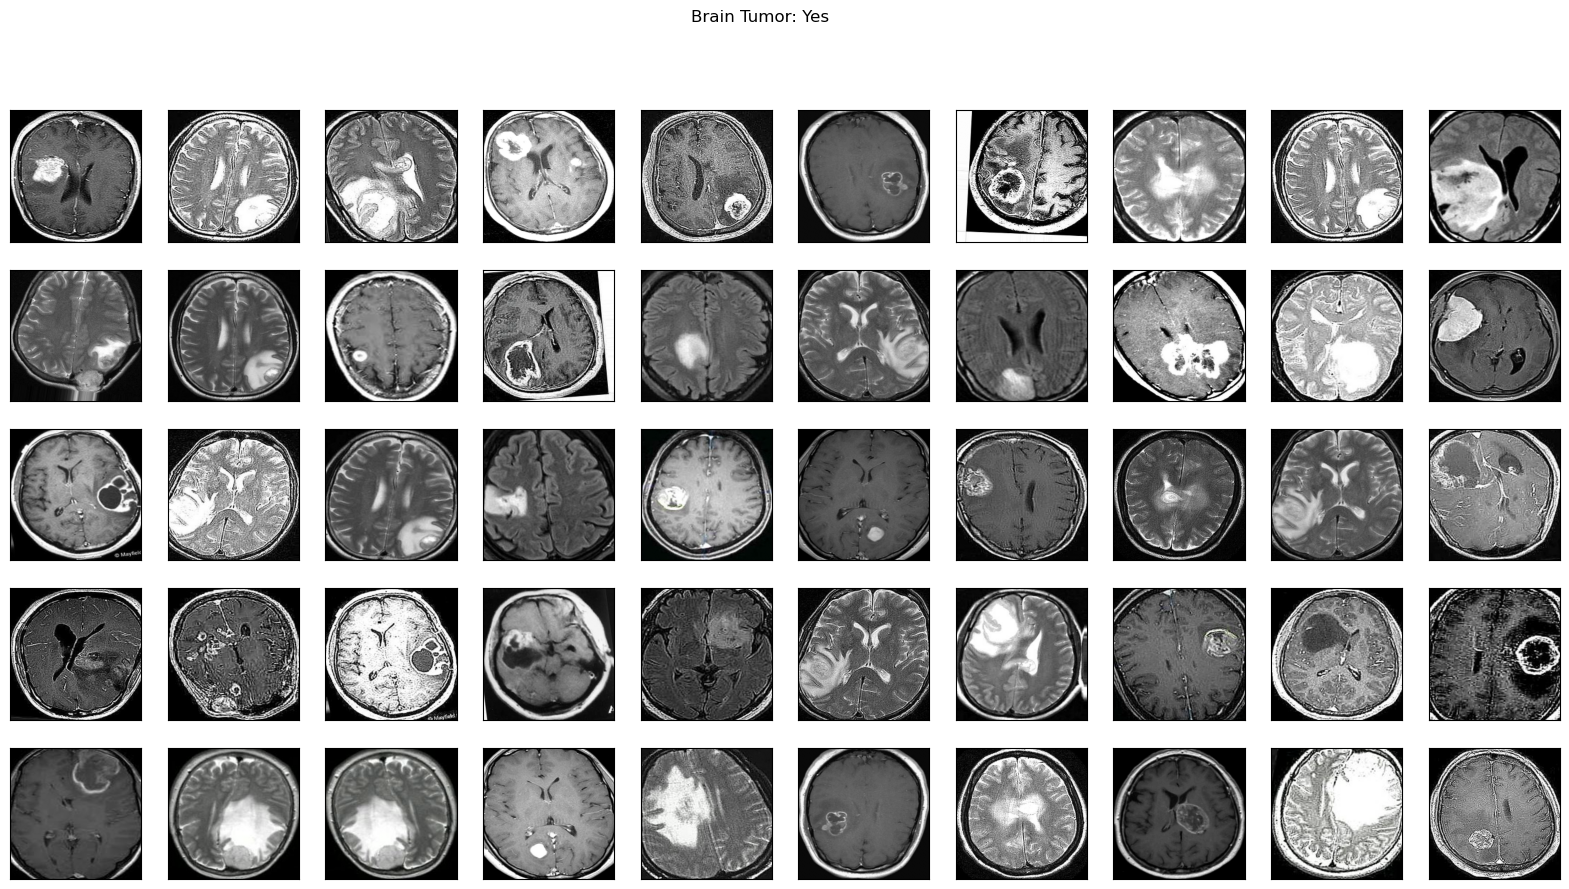

In [19]:
plot_sample_images(X, y)

In [20]:
import shutil

# Replace folder_path with the path of the folder you want to delete
folder_path = 'D:/Brain tumor Detection/archive/yes'
folder_path2 = 'D:/Brain tumor Detection/archive/no'
folder_path3 = 'D:/Brain tumor Detection/augmented data'

# Use shutil.rmtree() to delete the folder and all its contents
shutil.rmtree(folder_path)
shutil.rmtree(folder_path2)
shutil.rmtree(folder_path3)

In [21]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [23]:
del X
del y
     

In [24]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 6299
number of development examples = 1350
number of test examples = 1350
X_train shape: (6299, 240, 240, 3)
Y_train shape: (6299, 1)
X_val (dev) shape: (1350, 240, 240, 3)
Y_val (dev) shape: (1350, 1)
X_test shape: (1350, 240, 240, 3)
Y_test shape: (1350, 1)


In [25]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [26]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2

def build_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Load the VGG16 model with pre-trained weights, excluding the top layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the VGG16 model so that they are not trained during transfer learning
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Extract features from the VGG16 model
    X = vgg16_base(X_input)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # First convolutional layer
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # First max pooling layer
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # Second convolutional layer
    X = Conv2D(64, (3,3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 55, 55, 64)

    # Second max pooling layer
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 13, 13, 64)

    # First Average pooling layer
    X = AveragePooling2D((2, 2), name='Avg_pool0')(X) # shape=(?, 6, 6, 64)

    # Third convolutional layer
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 4, 4, 128)

    # Second Average pooling layer
    X = AveragePooling2D((2, 2), name='Avg_pool1')(X) # shape=(?, 2, 2, 128)

    # Fourth convolutional layer
    X = Conv2D(128, (1,1), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3', momentum=0.9)(X)
    X = Activation('relu')(X) # shape=(?, 2, 2, 256)

    # Fourth max pooling layer
    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 512)

    # DROPOUT
    X = Dropout(0.3)(X)

    # FULLYCONNECTED
    X = Dense(1,activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Define the optimizer with a learning rate of 0.001.
    optimizer = RMSprop(lr=0.001)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [27]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [28]:
model = build_model(IMG_SHAPE)



58889256/58889256 [==============================] - 5s 0us/step


In [29]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [31]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [34]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy]
filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.model"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25



197/197 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7481INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-01-0.80.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-01-0.80.model.model\assets


197/197 [==============================] - 64s 317ms/step - loss: 0.5194 - accuracy: 0.7481 - val_loss: 0.4713 - val_accuracy: 0.7970
Epoch 2/25
197/197 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8666INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-02-0.79.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-02-0.79.model.model\assets


197/197 [==============================] - 57s 292ms/step - loss: 0.3165 - accuracy: 0.8666 - val_loss: 0.4156 - val_accuracy: 0.7926
Epoch 3/25
197/197 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9027INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-03-0.77.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-03-0.77.model.model\assets


197/197 [==============================] - 59s 301ms/step - loss: 0.2403 - accuracy: 0.9027 - val_loss: 0.6075 - val_accuracy: 0.7748
Epoch 4/25
197/197 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9267INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-04-0.95.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-04-0.95.model.model\assets


197/197 [==============================] - 59s 298ms/step - loss: 0.1930 - accuracy: 0.9267 - val_loss: 0.1435 - val_accuracy: 0.9452
Epoch 5/25
197/197 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9394INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-05-0.83.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-05-0.83.model.model\assets


197/197 [==============================] - 58s 297ms/step - loss: 0.1592 - accuracy: 0.9394 - val_loss: 0.8229 - val_accuracy: 0.8319
Epoch 6/25
197/197 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9522INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-06-0.81.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-06-0.81.model.model\assets


197/197 [==============================] - 59s 299ms/step - loss: 0.1363 - accuracy: 0.9522 - val_loss: 0.5741 - val_accuracy: 0.8148
Epoch 7/25
197/197 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9606INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-07-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-07-0.97.model.model\assets


197/197 [==============================] - 60s 306ms/step - loss: 0.1112 - accuracy: 0.9606 - val_loss: 0.0776 - val_accuracy: 0.9719
Epoch 8/25
197/197 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9649INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-08-0.74.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-08-0.74.model.model\assets


197/197 [==============================] - 58s 297ms/step - loss: 0.0987 - accuracy: 0.9649 - val_loss: 0.8290 - val_accuracy: 0.7363
Epoch 9/25
197/197 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9684INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-09-0.96.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-09-0.96.model.model\assets


197/197 [==============================] - 58s 296ms/step - loss: 0.0919 - accuracy: 0.9684 - val_loss: 0.1002 - val_accuracy: 0.9637
Epoch 10/25
197/197 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9719INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-10-0.95.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-10-0.95.model.model\assets


197/197 [==============================] - 58s 295ms/step - loss: 0.0837 - accuracy: 0.9719 - val_loss: 0.1500 - val_accuracy: 0.9452
Epoch 11/25
197/197 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9781INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-11-0.96.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-11-0.96.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0666 - accuracy: 0.9781 - val_loss: 0.1034 - val_accuracy: 0.9622
Epoch 12/25
197/197 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9805INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-12-0.98.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-12-0.98.model.model\assets


197/197 [==============================] - 58s 293ms/step - loss: 0.0591 - accuracy: 0.9805 - val_loss: 0.0647 - val_accuracy: 0.9778
Epoch 13/25
197/197 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9802INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-13-0.98.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-13-0.98.model.model\assets


197/197 [==============================] - 58s 295ms/step - loss: 0.0575 - accuracy: 0.9802 - val_loss: 0.0718 - val_accuracy: 0.9815
Epoch 14/25
197/197 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9811INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-14-0.93.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-14-0.93.model.model\assets


197/197 [==============================] - 59s 297ms/step - loss: 0.0536 - accuracy: 0.9811 - val_loss: 0.3310 - val_accuracy: 0.9274
Epoch 15/25
197/197 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9827INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-15-0.85.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-15-0.85.model.model\assets


197/197 [==============================] - 58s 295ms/step - loss: 0.0518 - accuracy: 0.9827 - val_loss: 0.5592 - val_accuracy: 0.8541
Epoch 16/25
197/197 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9829INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-16-0.96.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-16-0.96.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0626 - accuracy: 0.9829 - val_loss: 0.1082 - val_accuracy: 0.9644
Epoch 17/25
197/197 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9835INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-17-0.96.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-17-0.96.model.model\assets


197/197 [==============================] - 58s 296ms/step - loss: 0.0521 - accuracy: 0.9835 - val_loss: 0.1349 - val_accuracy: 0.9630
Epoch 18/25
197/197 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9844INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-18-0.92.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-18-0.92.model.model\assets


197/197 [==============================] - 58s 296ms/step - loss: 0.0539 - accuracy: 0.9844 - val_loss: 0.3300 - val_accuracy: 0.9163
Epoch 19/25
197/197 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9859INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-19-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-19-0.97.model.model\assets


197/197 [==============================] - 58s 295ms/step - loss: 0.0442 - accuracy: 0.9859 - val_loss: 0.0721 - val_accuracy: 0.9748
Epoch 20/25
197/197 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9917INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-20-0.84.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-20-0.84.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.9634 - val_accuracy: 0.8356
Epoch 21/25
197/197 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9857INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-21-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-21-0.97.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0452 - accuracy: 0.9857 - val_loss: 0.0826 - val_accuracy: 0.9696
Epoch 22/25
197/197 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9887INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-22-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-22-0.97.model.model\assets


197/197 [==============================] - 58s 293ms/step - loss: 0.0376 - accuracy: 0.9887 - val_loss: 0.1088 - val_accuracy: 0.9719
Epoch 23/25
197/197 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9868INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-23-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-23-0.97.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0501 - accuracy: 0.9868 - val_loss: 0.0961 - val_accuracy: 0.9704
Epoch 24/25
197/197 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9906INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-24-0.97.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-24-0.97.model.model\assets


197/197 [==============================] - 58s 294ms/step - loss: 0.0326 - accuracy: 0.9906 - val_loss: 0.1097 - val_accuracy: 0.9719
Epoch 25/25
197/197 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9884INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-25-0.93.model.model\assets


INFO:tensorflow:Assets written to: models/models\cnn-parameters-improvement-25-0.93.model.model\assets


197/197 [==============================] - 58s 296ms/step - loss: 0.0494 - accuracy: 0.9884 - val_loss: 0.2504 - val_accuracy: 0.9274
Elapsed time: 0:25:25.3


In [37]:
history = model.history.history

In [38]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [39]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

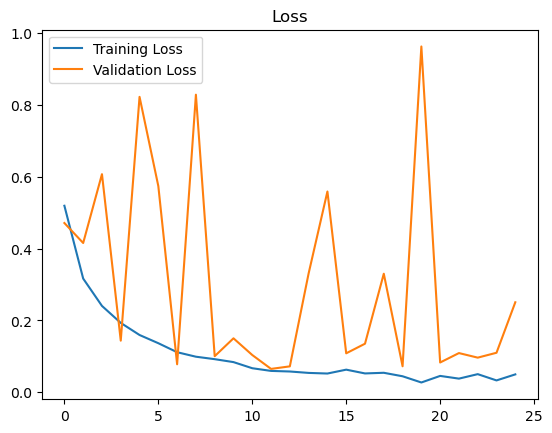

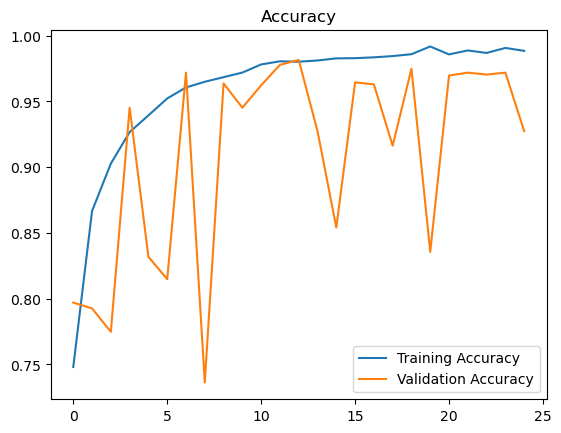

In [40]:
plot_metrics(history)

In [43]:
best_model = load_model(filepath='D:/Brain tumor Detection/models/models/cnn-parameters-improvement-24-0.97.model.model')

In [44]:
best_model.metrics_names

['loss', 'accuracy']

In [45]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

43/43 [==============================] - 4s 81ms/step - loss: 0.0986 - accuracy: 0.9756


In [46]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.09856320917606354
Test Accuracy = 0.9755555391311646


In [47]:
y_test_prob = best_model.predict(X_test)

43/43 [==============================] - 4s 79ms/step


In [48]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9757174392935982


In [49]:
y_val_prob = best_model.predict(X_val)

43/43 [==============================] - 3s 79ms/step


In [50]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9726224783861672


In [51]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")


In [52]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 6299
Percentage of positive examples: 49.976186696301%, number of pos examples: 3148
Percentage of negative examples: 50.023813303699%, number of neg examples: 3151
Validation Data:
Number of examples: 1350
Percentage of positive examples: 50.666666666666664%, number of pos examples: 684
Percentage of negative examples: 49.333333333333336%, number of neg examples: 666
Testing Data:
Number of examples: 1350
Percentage of positive examples: 49.48148148148148%, number of pos examples: 668
Percentage of negative examples: 50.51851851851852%, number of neg examples: 682


In [53]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate model performance on test set
y_test_pred = (y_test_prob > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_acc = (tp + tn) / (tn + fp + fn + tp)
test_precision = tp / (tp + fp)
test_recall = tp / (tp + fn)
test_f1 = 2 * ((test_precision * test_recall) / (test_precision + test_recall))

# Evaluate model performance on validation set
y_val_pred = (y_val_prob > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
val_acc = (tp + tn) / (tn + fp + fn + tp)
val_precision = tp / (tp + fp)
val_recall = tp / (tp + fn)
val_f1 = 2 * ((val_precision * val_recall) / (val_precision + val_recall))

# Print performance table
print("Model performance:")
print("Test set:")
print(f"Accuracy: {test_acc:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 score: {test_f1:.2f}")
print(classification_report(y_test, y_test_pred))

print("Validation set:")
print(f"Accuracy: {val_acc:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1 score: {val_f1:.2f}")
print(classification_report(y_val, y_val_pred))


Model performance:
Test set:
Accuracy: 0.98
Precision: 0.96
Recall: 0.99
F1 score: 0.98
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       682
           1       0.96      0.99      0.98       668

    accuracy                           0.98      1350
   macro avg       0.98      0.98      0.98      1350
weighted avg       0.98      0.98      0.98      1350

Validation set:
Accuracy: 0.97
Precision: 0.96
Recall: 0.99
F1 score: 0.97
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       666
           1       0.96      0.99      0.97       684

    accuracy                           0.97      1350
   macro avg       0.97      0.97      0.97      1350
weighted avg       0.97      0.97      0.97      1350



In [55]:
tf.keras.models.save_model(best_model,'model.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model = best_model)
model_tflite = converter.convert()
open("CNNBrainTumorModelVGG16.tflite","wb").write(model_tflite)


INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: C:\Users\saive\AppData\Local\Temp\tmp75sd9232\assets


INFO:tensorflow:Assets written to: C:\Users\saive\AppData\Local\Temp\tmp75sd9232\assets


460856

In [57]:
import cv2
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
model_path = 'D:/Brain tumor Detection/CNNBrainTumorModelVGG16.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
img_path = 'D:/Brain tumor Detection/Google Images testing/test1.jpg'   # download any image from google and insert it's path
img = cv2.imread(img_path)
img = crop_brain_contour(img, plot=False)
img = cv2.resize(img, (240, 240))
img = img.astype('float32') / 255.0

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
pred_prob = output_data[0][0]

# Classify the image based on the prediction probability
if pred_prob > 0.5:
    print('Tumor present with probability {:.2f}%'.format(pred_prob * 100))
else:
    print('Tumor not present with probability {:.2f}%'.format((1 - pred_prob) * 100))


Tumor present with probability 99.99%
